# Variance Reduction for Linear Regression

This is a toy example showcasing the usage of the sampler. We will look at how importance sampling for variance reduction helps in solving linear regression with SGD. The example is insired by [1].

In [31]:
import numpy as np
import vrb
import matplotlib.pyplot as plt

np.random.seed(0)

# dataset size and dimension
n, d = 1000, 10

nr_epoch = 50
step_size = 0.001

We sample a dataset $\mathbf{X}$ where the features are sampled according to normal distributions with different means and variances. We then randomly select 10 points, and rescale them by 10. This way, we produce a dataset that amplifies the benefit of importance sampling.

In [32]:
X = np.random.normal(loc=np.random.rand(d),
                     scale=np.random.rand(d) * 10,
                     size=(n, d))

ind_to_scale = np.random.choice(n, size=10)
X[ind_to_scale, :] *= 10

We sample a vector $\mathbf{w} \sim \mathcal{N}(0, 25)$ and generate the dependent variables $y_i = \mathbf{w}^\intercal \mathbf{x}_i+\varepsilon_i$, where $\varepsilon_i \sim \mathcal{N}(0, 1)$ is the noise.

In [33]:
w_orig = np.random.normal(loc=0, scale=5, size=d)
y = X.dot(w_orig) + np.random.randn(n)

The performance is measured using the mean squared error.

In [34]:
def mse(w, X, y):
    return 0.5 * np.mean((X.dot(w) - y) ** 2)

We are now ready to employ VRB and compare it to uniform sampling. In each round, we draw one sample and perform the SGD step based on it.

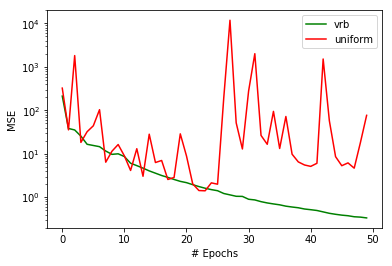

In [35]:
# Calculate the reference mse score
reference_score = mse(w_orig, X, y)

# Instantiate the sampler. 
# We deliberately misspecify the regularization parameter by setting it to 1. Cross-validation improves the performance.
sampler = vrb.VarianceReducerBandit(n=n, random_state=0, reg=1, theta=0.3)

uniform_scores = np.zeros(nr_epoch)
vrb_scores = np.zeros(nr_epoch)

w = np.zeros(d)
for epoch in range(nr_epoch):
    for i in range(n):
        # sample index and get its associated probability
        ind, p = sampler.sample(1)
        
        # set the weight inversely proportional to p
        weigth = 1. / p / n
        
        # SGD step
        grad = (X[ind].dot(w) - y[ind]) * X[ind]
        w = w - step_size / np.sqrt(i + 1) * weigth.dot(grad)
        
        # feed loss back to sampler
        sampler.update(np.linalg.norm(grad))
        
    vrb_scores[epoch] = mse(w, X, y)

w = np.zeros(d)
for epoch in range(nr_epoch):
    for i in range(n):
        ind = np.random.choice(n)
        grad = (X[ind].dot(w) - y[ind]) * X[ind]
        w = w - step_size / np.sqrt(i + 1) * grad
    uniform_scores[epoch] = mse(w, X, y)

line1, = plt.semilogy(vrb_scores - reference_score, color='green', label='vrb')
line2, = plt.semilogy(uniform_scores - reference_score, color='red', label='uniform')
plt.xlabel("# Epochs")
plt.ylabel("MSE")

plt.legend(handles=[line1, line2])
plt.show()


[1] Salehi, Farnood, Elisa Celis, and Patrick Thiran. "Stochastic Optimization with Bandit Sampling." arXiv preprint arXiv:1708.02544 (2017).